# Explore AST

Bill Ingram <waingram@vt.edu>  
October 5, 2021 
  
This notebook generates an abstract syntax tree (AST) from a given Python program. 

In [1]:
import ast

In [2]:
# with open('execution_log.py', 'r') as source:
#     tree = ast.parse(source.read())
    
def parse_file(filename):
    with open(filename) as f:
        return ast.parse(f.read(), filename=filename)

In [3]:
tree = parse_file('execution_log.py')
dump = ast.dump(tree, indent=2)
# print(dump)

Find the assignment that is the closest to a given line number.  
  
Credit: Finding definitions from a source file and a line number in Python. Julien Danjou.  
Retrieved October 11, 2021 from [https://julien.danjou.info/finding-definitions-from-a-source-file-and-a-line-number-in-python/](https://julien.danjou.info/finding-definitions-from-a-source-file-and-a-line-number-in-python/)

In [4]:
def filename_and_lineno_to_def(filename, lineno):
    candidate = None
    for item in ast.walk(parse_file(filename)):
#         if hasattr(item, 'lineno'):
#             print(item.lineno)
#             print(item)
#         if isinstance(item, (ast.FunctionDef, ast.AsyncFunctionDef, ast.ClassDef, ast.Assign)):
        if hasattr(item, 'lineno'):
            if item.lineno == lineno:
                candidate = item
#             if item.lineno > lineno:
#                 # Ignore whatever is after our line
#                 continue
#             if candidate:
#                 distance = lineno - item.lineno
#                 if distance < (lineno - candidate.lineno):
#                     candidate = item
#             else:
#                 candidate = item

    if candidate:
        return candidate

In [5]:
stmt = filename_and_lineno_to_def('execution_log.py', 100) 
print(ast.dump(stmt, indent=2))

Name(id='km', ctx=Load())


**New Approach**

In [6]:
def mid(x,y,z):
    m = z
    if y < z:
        if x < y:
            m = y
        elif x < z:
            m = x
    else:
        if x > y:
            m = y
        elif x > z:
            m = x
    print(m)
    return m


In [7]:
import inspect

tree = ast.parse(inspect.getsource(mid))

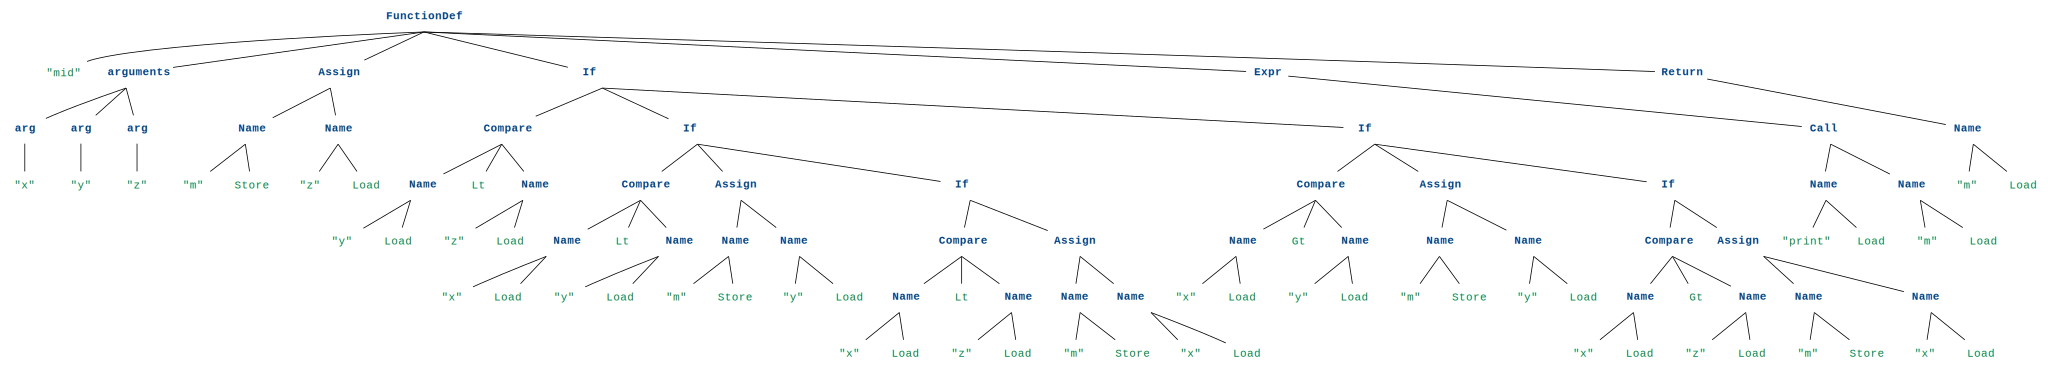

In [8]:
import showast

def show_ast(tree):
    showast.show_ast(tree)
    
show_ast(tree)

In [9]:
from types import FunctionType, FrameType, TracebackType
from typing import cast, Dict, Any, Tuple, Callable, Optional, Type

class StackInspector:
    """Provide functions to inspect the stack"""

    def caller_frame(self) -> FrameType:
        """Return the frame of the caller."""

        # Walk up the call tree until we leave the current class
        frame = cast(FrameType, inspect.currentframe())

        while self.our_frame(frame):
            frame = cast(FrameType, frame.f_back)

        return frame

    def our_frame(self, frame: FrameType) -> bool:
        """Return true if `frame` is in the current (inspecting) class."""
        return isinstance(frame.f_locals.get('self'), self.__class__)

class DataTracker(StackInspector):
    """Track data accesses during execution"""

    def __init__(self, log: bool = False) -> None:
        """Constructor. If `log` is set, turn on logging."""
        self.log = log
        
class DataTracker(DataTracker):
    def get(self, name: str, value: Any) -> Any:
        """Track getting `value` from `name`."""

        if self.log:
            caller_func, lineno = self.caller_location()
            print(f"{caller_func.__name__}:{lineno}: getting {name}")

        return value


In [13]:
from ast import NodeTransformer, NodeVisitor, Name, AST, \
    Module, Load, Store, \
    Attribute, With, withitem, keyword, Call, Expr, \
    Assign, AugAssign, AnnAssign, Assert

class TrackGetTransformer(NodeTransformer):
    def visit_Name(self, node: Name) -> AST:
        self.generic_visit(node)

        if is_internal(node.id):
            # Do not change built-in names and types
            return node

        if node.id == DATA_TRACKER:
            # Do not change own accesses
            return node

        if not isinstance(node.ctx, Load):
            # Only change loads (not stores, not deletions)
            return node

        new_node = make_get_data(node.id)
        ast.copy_location(new_node, node)
        return new_node

In [14]:
import typing 

def is_internal(id: str) -> bool:
    """Return True if `id` is a built-in function or type"""
    return (id in dir(__builtins__) or id in dir(typing))

In [16]:
print(dir(typing))
print(dir(__builtins__))

['ABCMeta', 'AbstractSet', 'Annotated', 'Any', 'AnyStr', 'AsyncContextManager', 'AsyncGenerator', 'AsyncIterable', 'AsyncIterator', 'Awaitable', 'BinaryIO', 'ByteString', 'CT_co', 'Callable', 'ChainMap', 'ClassVar', 'Collection', 'Container', 'ContextManager', 'Coroutine', 'Counter', 'DefaultDict', 'Deque', 'Dict', 'EXCLUDED_ATTRIBUTES', 'Final', 'ForwardRef', 'FrozenSet', 'Generator', 'Generic', 'GenericAlias', 'Hashable', 'IO', 'ItemsView', 'Iterable', 'Iterator', 'KT', 'KeysView', 'List', 'Literal', 'Mapping', 'MappingView', 'Match', 'MethodDescriptorType', 'MethodWrapperType', 'MutableMapping', 'MutableSequence', 'MutableSet', 'NamedTuple', 'NamedTupleMeta', 'NewType', 'NoReturn', 'Optional', 'OrderedDict', 'Pattern', 'Protocol', 'Reversible', 'Sequence', 'Set', 'Sized', 'SupportsAbs', 'SupportsBytes', 'SupportsComplex', 'SupportsFloat', 'SupportsIndex', 'SupportsInt', 'SupportsRound', 'T', 'TYPE_CHECKING', 'T_co', 'T_contra', 'Text', 'TextIO', 'Tuple', 'Type', 'TypeVar', 'TypedDic

In [17]:
DATA_TRACKER = '_data'

In [18]:
def make_get_data(id: str, method: str = 'get') -> Call:
    return Call(func=Attribute(value=Name(id=DATA_TRACKER, ctx=Load()), 
                               attr=method, ctx=Load()),
                args=[ast.Str(s=id), Name(id=id, ctx=Load())],
                keywords=[])

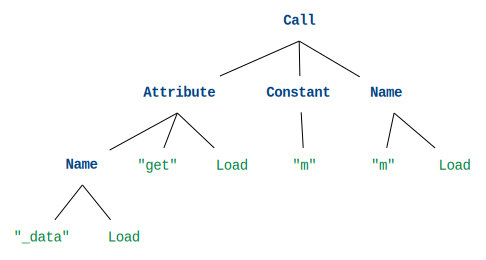

In [19]:
show_ast(Module(body=[make_get_data("m")]))

In [20]:
print(ast.dump(ast.parse("_data.get('m', m)")))

Module(body=[Expr(value=Call(func=Attribute(value=Name(id='_data', ctx=Load()), attr='get', ctx=Load()), args=[Constant(value='m'), Name(id='m', ctx=Load())], keywords=[]))], type_ignores=[])


In [21]:

TrackGetTransformer().visit(tree);